In [37]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sklearn.utils import shuffle
from torch import autograd
from torch.autograd import Variable

In [38]:
import matplotlib.pyplot as plt

In [39]:
reading = np.load('reading_np.npy')
phn = np.load('phone_np.npy')
drinking = np.load('drinking_np.npy')
cleaning = np.load('cleaning_np.npy')
walking = np.load('walking_np.npy')
cutting = np.load('cutting_np.npy')

In [40]:
y_reading = np.full(50,0)
y_phn = np.full(50,1)
y_drink = np.full(50,2)
y_cleaning = np.full(50,3)
y_walking = np.full(50,4)
y_cutting = np.full(50,5)
Y = np.concatenate((y_reading, y_phn, y_drink, y_cleaning, y_walking, y_cutting), axis = 0)

In [41]:
N = Y.shape[0]

N_actions = 6

dtype = torch.FloatTensor

In [42]:
one_hot_labels = np.zeros((N, N_actions))
one_hot_labels[np.arange(N), Y] = 1

In [43]:
X = np.vstack((phn,reading,drinking,cleaning,walking,cutting))


temp = frameMat

nums_skeleton = 20
n_frames = 273
frameMat_temp = np.zeros((n_frames, n_features))
for i in range(n_frames):
    Origin = (temp[i, 12:15] + temp[i, 15:18] + temp[i, 18:21]) / 3
    for j in range(num_joints):
        index = 3*j
        frameMat_temp[i, index] = temp[i, index] - Origin[0]
        frameMat_temp[i, index + 1] = temp[i, index + 1] - Origin[1]
        frameMat_temp[i, index + 2] = temp[i, index + 2] - Origin[2]

In [44]:
mean = X.mean(axis= 0)
std  = X.std(axis = 0)
X = (X - mean)/std

In [45]:
s = np.arange(X.shape[0])
np.random.shuffle(s)
shuffled_x = X[s]
shuffled_y = Y[s]
train_x = shuffled_x[0:int(0.8*N)]
train_y = shuffled_y[0:int(0.8*N)]
test_x = shuffled_x[int(0.8*N):]
test_y = shuffled_y[int(0.8*N):]

In [46]:
train_x = Variable(torch.from_numpy(train_x)).float()
test_x = Variable(torch.from_numpy(test_x))
test_x = test_x.float().cuda()
labels = Variable(torch.from_numpy(train_y))
test_y = Variable(torch.from_numpy(test_y))

In [47]:
train_x.shape

torch.Size([240, 273, 20, 3])

In [48]:
test_x.shape

torch.Size([60, 273, 20, 3])

In [49]:
class ActionNet(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, label_size, batch_size):
        super(ActionNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)
        self.hidden2label = nn.Linear(SEQ_LENGTH*hidden_dim, label_size)
        self.hidden = self.init_hidden()
        
    def init_hidden(self):
        # the first is the hidden h
        # the second is the cell  c
        return (autograd.Variable(torch.zeros(1, self.batch_size, self.hidden_dim)).cuda(),
                autograd.Variable(torch.zeros(1, self.batch_size, self.hidden_dim)).cuda())

    def forward(self, x):
        #print(x.shape)
        lstm_out, self.hidden = self.lstm(x, self.hidden)
        y  = self.hidden2label(lstm_out.view(BATCH_SIZE,-1))
        log_probs = F.softmax(y, dim=1)
        return y


In [50]:
EMBEDDING_DIM = 60
HIDDEN_DIM = 32
SEQ_LENGTH = train_x.shape[1]
LABEL_SIZE = N_actions
BATCH_SIZE = 30

num_batches = train_x.shape[0]/BATCH_SIZE
num_test_batches = test_x.shape[0]/BATCH_SIZE
net = ActionNet(embedding_dim=EMBEDDING_DIM, hidden_dim=HIDDEN_DIM, label_size=LABEL_SIZE, batch_size=BATCH_SIZE)

net = net.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr = 0.001)

In [51]:
num_epochs = 100
train_loss_list = []
test_loss_list = []
for epoch in range(num_epochs):
    running_loss = 0
    test_running_loss = 0
    for batch in range(int(num_test_batches)):
        x = test_x[BATCH_SIZE*batch:BATCH_SIZE*(batch+1)].permute(1,0,2,3).contiguous()
        x = x.view(SEQ_LENGTH, BATCH_SIZE, -1)
        out = net(x)
        loss = criterion(out,test_y[BATCH_SIZE*batch:BATCH_SIZE*(batch+1)].cuda())
        test_running_loss += loss.data[0]
    
    test_loss_list.append(test_running_loss)
    for batch in range(int(num_batches)):
        x = train_x[BATCH_SIZE*batch:BATCH_SIZE*(batch+1)].permute(1,0,2,3).contiguous().cuda()
        x = x.view(SEQ_LENGTH, BATCH_SIZE, -1)
        optimizer.zero_grad()
        net.hidden = net.init_hidden()
        
        out = net(x)
        #print(out.shape)
        loss = criterion(out,labels[BATCH_SIZE*batch:BATCH_SIZE*(batch+1)].cuda())
        running_loss += loss.data[0]
        loss.backward()
        optimizer.step()
    train_loss_list.append(running_loss)
        
    print ('Epoch [%d/%d], Loss: %.4f, Test Loss: %.4f' %(epoch+1, num_epochs, running_loss, test_running_loss))

Epoch [1/100], Loss: 14.6913, Test Loss: 3.5848
Epoch [2/100], Loss: 9.0627, Test Loss: 3.9306
Epoch [3/100], Loss: 6.3569, Test Loss: 4.2686
Epoch [4/100], Loss: 4.2222, Test Loss: 4.6545
Epoch [5/100], Loss: 2.5930, Test Loss: 5.2555
Epoch [6/100], Loss: 1.5250, Test Loss: 5.8879
Epoch [7/100], Loss: 0.9278, Test Loss: 6.4241
Epoch [8/100], Loss: 0.6181, Test Loss: 6.7519
Epoch [9/100], Loss: 0.4084, Test Loss: 7.1851
Epoch [10/100], Loss: 0.2912, Test Loss: 7.4980
Epoch [11/100], Loss: 0.2241, Test Loss: 7.7821
Epoch [12/100], Loss: 0.1795, Test Loss: 7.9437
Epoch [13/100], Loss: 0.1495, Test Loss: 8.0957
Epoch [14/100], Loss: 0.1275, Test Loss: 8.2149
Epoch [15/100], Loss: 0.1110, Test Loss: 8.3464
Epoch [16/100], Loss: 0.0979, Test Loss: 8.4538
Epoch [17/100], Loss: 0.0873, Test Loss: 8.5601
Epoch [18/100], Loss: 0.0786, Test Loss: 8.6496
Epoch [19/100], Loss: 0.0712, Test Loss: 8.7427
Epoch [20/100], Loss: 0.0649, Test Loss: 8.8178
Epoch [21/100], Loss: 0.0594, Test Loss: 8.9018


In [52]:
def plotGraph(y1,y2,x):
    plt.plot(x,y1, label = "Train loss")
    plt.plot(x,y2, label="Test Loss")
    plt.legend()
    plt.show

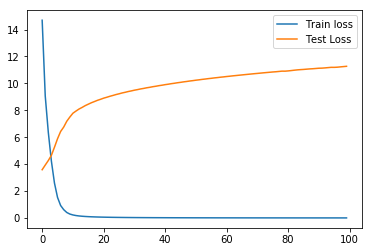

In [53]:
plotGraph(train_loss_list, test_loss_list, [i for i in range(num_epochs)])

In [54]:
def pred(x):
    out = net(x)
    weight, action = torch.max(out, dim=1)
    return action.data.cpu().numpy()

In [55]:
def accuracy(x,labels):
    N = labels.shape[0]
    predicted = pred(x.cuda())
    i = 0
    for yhat,y in zip(predicted,labels):
        
        if yhat == y:
            i += 1
    return i

In [56]:
print(train_x.shape)

torch.Size([240, 273, 20, 3])


In [57]:
test_x.shape

torch.Size([60, 273, 20, 3])

In [70]:
def get_Accuracy(x,y):
    x = x.float().cuda()
    n_testbatch = int(x.shape[0]/BATCH_SIZE)
    n_correct = 0
    for i in range(n_testbatch):
        test_batch_x = x[i*BATCH_SIZE:(i+1)*BATCH_SIZE].permute(1,0,2,3).contiguous()
        test_batch_x = test_batch_x.view(SEQ_LENGTH, BATCH_SIZE,-1)
        print(test_batch_x.shape)
        n_correct += accuracy(test_batch_x, y[i*BATCH_SIZE:(i+1)*BATCH_SIZE])
    print("Accuracy :", n_correct*100/x.shape[0])
    

In [71]:
get_Accuracy(test_x,test_y.data.numpy())

torch.Size([273, 30, 60])
torch.Size([273, 30, 60])
Accuracy : 13.333333333333334


In [72]:
get_Accuracy(train_x, train_y)

torch.Size([273, 30, 60])
torch.Size([273, 30, 60])
torch.Size([273, 30, 60])
torch.Size([273, 30, 60])
torch.Size([273, 30, 60])
torch.Size([273, 30, 60])
torch.Size([273, 30, 60])
torch.Size([273, 30, 60])
Accuracy : 100.0


In [61]:
torch.save(net,"action_net.pt")

/usr/local/lib/python3.5/dist-packages/torch/serialization.py:158: UserWarning: Couldn't retrieve source code for container of type ActionNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
